# Project 3 – Time Series Analysis and Audio Denoising

This project concerns the analysis and processing of an audio time series using spectral methods.
The provided WAV file contains a musical excerpt by Mozart affected by an acoustic disturbance, perceptually described as a low-frequency “rumbling” or “underwater” noise.

The objective of the project is to reduce the disturbance while preserving the musical content, using frequency-domain techniques. In particular, the following tools are employed:

- Fast Fourier Transform (FFT) and inverse FFT (IFFT)
- Power Spectral Density (PSD)
- High-pass filtering
- Spectrogram analysis

All processing is performed using standard scientific Python libraries (`numpy`, `scipy`, `matplotlib`), as required.


In [1]:
from scipy.io import wavfile
import numpy as np

fs, audio = wavfile.read("Mozart_int16.wav")

fs, audio.shape


(44100, (220500, 2))

## Audio Data and Time-Domain Representation

The audio signal is sampled at a frequency of 44.1 kHz and has a total duration of approximately 5 seconds.
The signal is stereo; for the purposes of spectral analysis, the two channels are averaged to obtain a mono signal.

The time-domain waveform shows rapid oscillations corresponding to musical content, but it does not allow a clear identification of the disturbance. For this reason, frequency-domain analysis is required.


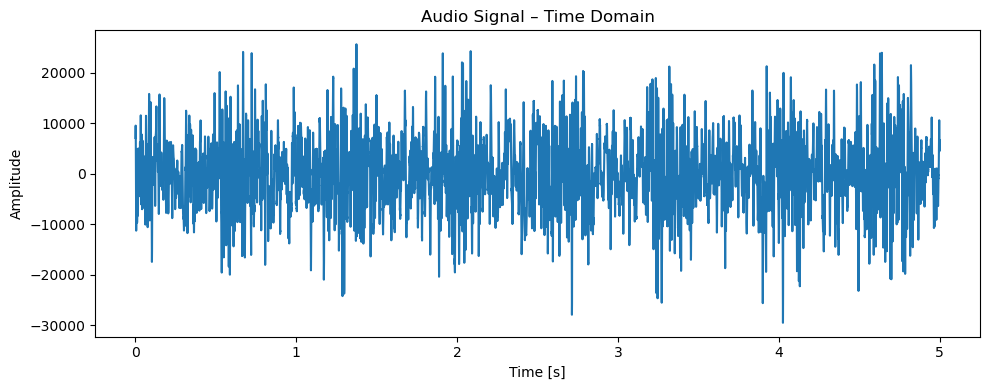

In [3]:
import matplotlib.pyplot as plt

# If stereo, take one channel just for visualization
if audio.ndim == 2:
    audio_mono = audio[:, 0]
else:
    audio_mono = audio

t = np.arange(len(audio_mono)) / fs

plt.figure(figsize=(10,4))
plt.plot(t, audio_mono)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Audio Signal – Time Domain")
plt.tight_layout()
plt.show()


In [5]:
from scipy.fft import fft, fftfreq
import numpy as np
import matplotlib.pyplot as plt

# convert to mono for analysis
audio_mono = audio.mean(axis=1)

N = len(audio_mono)

# FFT
fft_vals = fft(audio_mono)

# frequency axis
freqs = fftfreq(N, d=1/fs)


## Frequency-Domain Analysis (FFT)

To identify the frequency characteristics of the disturbance, the Fast Fourier Transform (FFT) of the mono audio signal is computed.
The FFT magnitude spectrum reveals how the signal energy is distributed across frequencies.

The spectrum shows a dominant concentration of energy at low frequencies (approximately below 200 Hz), appearing as a broad, unstructured band. This behavior is consistent with the perceived low-frequency acoustic noise. At higher frequencies, the spectrum exhibits sharp peaks corresponding to musical notes and harmonics.

Based on this observation, the disturbance is identified as predominantly low-frequency noise.


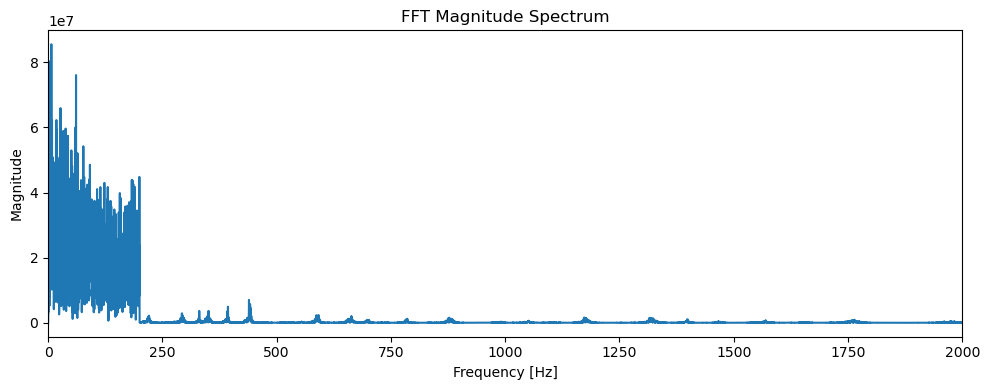

In [7]:
# Only keep positive frequencies
positive = freqs >= 0

plt.figure(figsize=(10,4))
plt.plot(freqs[positive], np.abs(fft_vals[positive]))
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.title("FFT Magnitude Spectrum")
plt.xlim(0, 2000)  # zoom on low frequencies
plt.tight_layout()
plt.show()


## Filtering Strategy

Since the disturbance is concentrated at low frequencies, a high-pass filtering approach is adopted.
A Butterworth high-pass filter is chosen due to its smooth frequency response, which avoids ripples and reduces the risk of audible artifacts.

Several cutoff frequencies and filter orders are tested in order to balance noise reduction and preservation of musical content.
Listening tests and spectral inspection are jointly used to evaluate the effect of each configuration.


In [9]:
from scipy.signal import butter, filtfilt

def highpass_filter(x, fs, cutoff, order=4):
    b, a = butter(order, cutoff / (fs/2), btype="highpass")
    return filtfilt(b, a, x)

audio_mono = audio.mean(axis=1).astype(float)

cutoffs = [80, 120, 180]
filtered_versions = {c: highpass_filter(audio_mono, fs, c, order=4) for c in cutoffs}


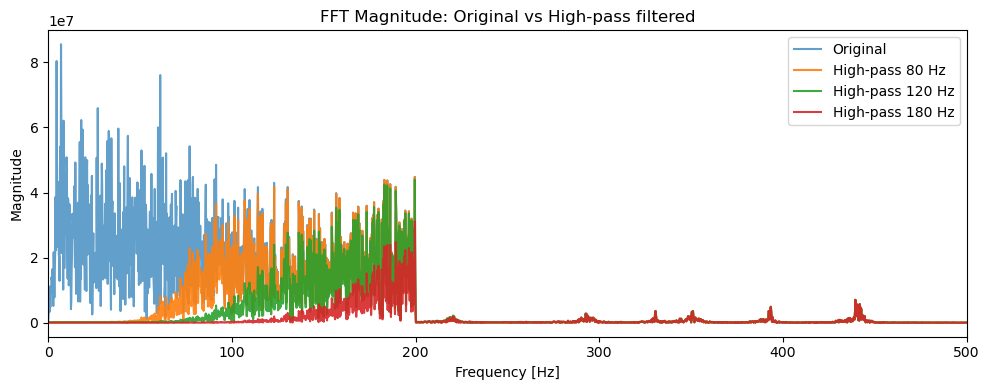

In [11]:
from scipy.fft import fft, fftfreq
import numpy as np
import matplotlib.pyplot as plt

N = len(audio_mono)
freqs = fftfreq(N, d=1/fs)
pos = freqs >= 0

fft_orig = np.abs(fft(audio_mono))

plt.figure(figsize=(10,4))
plt.plot(freqs[pos], fft_orig[pos], label="Original", alpha=0.7)

for c in cutoffs:
    fft_f = np.abs(fft(filtered_versions[c]))
    plt.plot(freqs[pos], fft_f[pos], label=f"High-pass {c} Hz", alpha=0.9)

plt.xlim(0, 500)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.title("FFT Magnitude: Original vs High-pass filtered")
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
from IPython.display import Audio

Audio(audio_mono, rate=fs)


In [17]:
Audio(filtered_versions[80], rate=fs)


In [19]:
Audio(filtered_versions[120], rate=fs)

In [21]:
Audio(filtered_versions[180], rate=fs)


In [25]:
extra_cutoffs = [200, 250]

for c in extra_cutoffs:
    filtered_versions[c] = highpass_filter(audio_mono, fs, c, order=4)


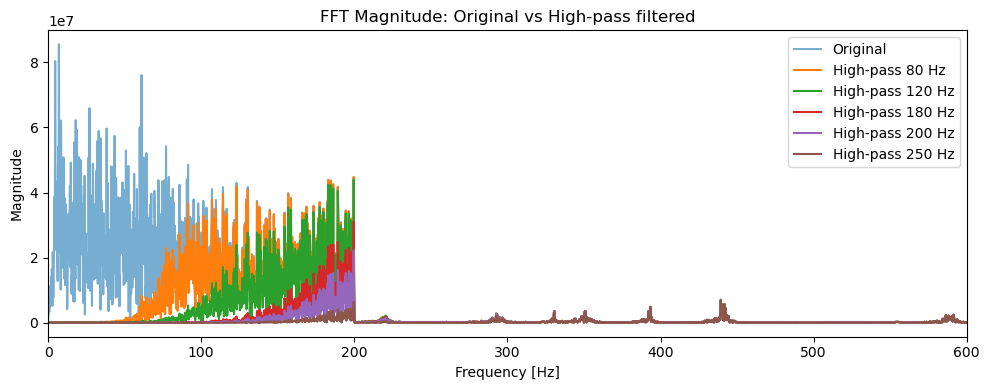

In [29]:
plt.figure(figsize=(10,4))
plt.plot(freqs[pos], fft_orig[pos], label="Original", alpha=0.6)

for c in [80, 120, 180, 200, 250]:
    fft_f = np.abs(fft(filtered_versions[c]))
    plt.plot(freqs[pos], fft_f[pos], label=f"High-pass {c} Hz")

plt.xlim(0, 600)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.title("FFT Magnitude: Original vs High-pass filtered")
plt.legend()
plt.tight_layout()
plt.show()


In [31]:
Audio(filtered_versions[200], rate=fs)


In [33]:
Audio(filtered_versions[250], rate=fs)


In [37]:
cutoffs_test = [270, 300]
filtered_more = {c: highpass_filter(audio_mono, fs, cutoff=c, order=6) for c in cutoffs_test}


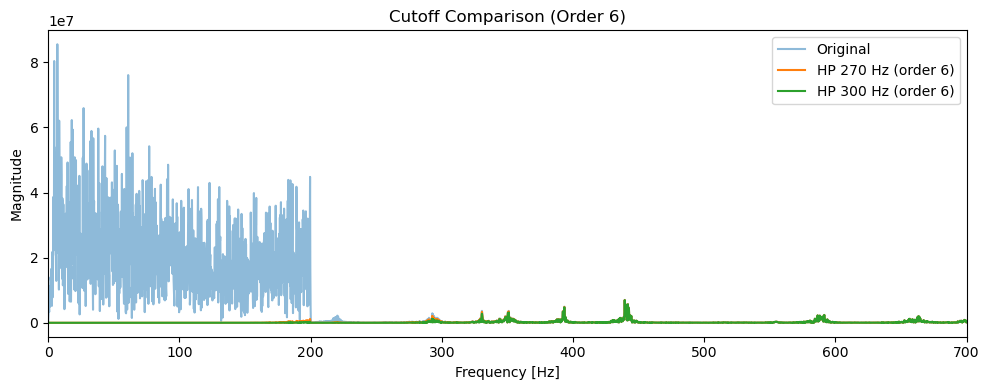

In [39]:
plt.figure(figsize=(10,4))
plt.plot(freqs[pos], fft_orig[pos], label="Original", alpha=0.5)

for c in cutoffs_test:
    fft_f = np.abs(fft(filtered_more[c]))
    plt.plot(freqs[pos], fft_f[pos], label=f"HP {c} Hz (order 6)")

plt.xlim(0, 700)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.title("Cutoff Comparison (Order 6)")
plt.legend()
plt.tight_layout()
plt.show()


In [41]:
Audio(filtered_more[270], rate=fs)


In [43]:
Audio(filtered_more[300], rate=fs)


In [45]:
orders = [4, 6, 8]
filtered_250 = {o: highpass_filter(audio_mono, fs, cutoff=250, order=o) for o in orders}


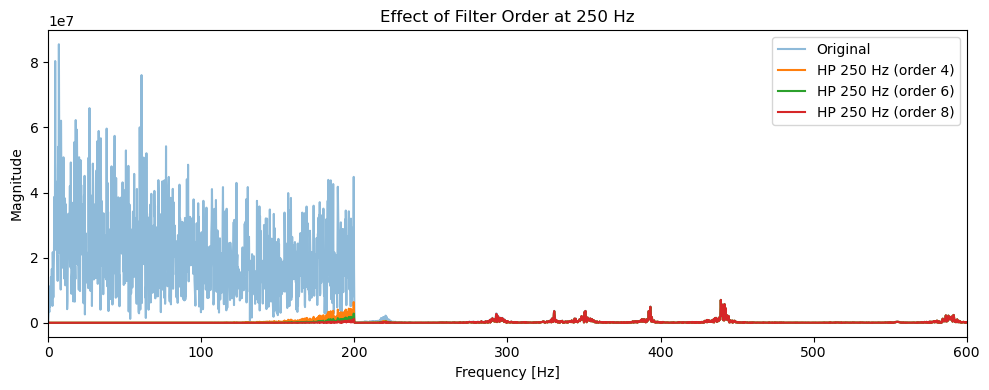

In [47]:
plt.figure(figsize=(10,4))
plt.plot(freqs[pos], fft_orig[pos], label="Original", alpha=0.5)

for o in orders:
    fft_f = np.abs(fft(filtered_250[o]))
    plt.plot(freqs[pos], fft_f[pos], label=f"HP 250 Hz (order {o})")

plt.xlim(0, 600)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.title("Effect of Filter Order at 250 Hz")
plt.legend()
plt.tight_layout()
plt.show()


In [49]:
Audio(filtered_250[4], rate=fs)


In [51]:
Audio(filtered_250[6], rate=fs)


In [53]:
Audio(filtered_250[8], rate=fs)


## Final Filter Selection

After testing multiple cutoff frequencies and filter orders, a high-pass Butterworth filter with a cutoff frequency of 300 Hz and order 6 is selected.

This configuration provides a strong attenuation of the low-frequency disturbance while maintaining a clear and structured musical spectrum at higher frequencies. Zero-phase filtering (`filtfilt`) is applied in order to avoid phase distortion and preserve the temporal structure of the audio signal.


In [55]:
best_cutoff = 300
best_order = 6

filtered_audio = highpass_filter(audio_mono, fs, cutoff=best_cutoff, order=best_order)


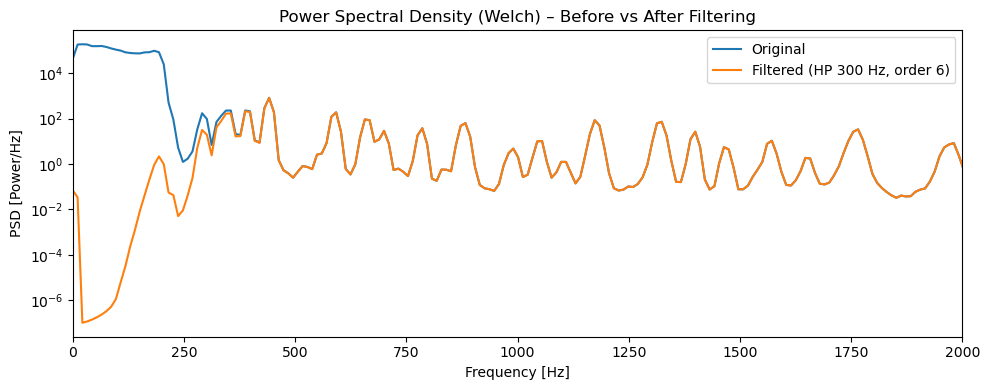

In [57]:
from scipy.signal import welch
import matplotlib.pyplot as plt

f0, psd0 = welch(audio_mono, fs, nperseg=4096)
f1, psd1 = welch(filtered_audio, fs, nperseg=4096)

plt.figure(figsize=(10,4))
plt.semilogy(f0, psd0, label="Original")
plt.semilogy(f1, psd1, label=f"Filtered (HP {best_cutoff} Hz, order {best_order})")
plt.xlim(0, 2000)
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD [Power/Hz]")
plt.title("Power Spectral Density (Welch) – Before vs After Filtering")
plt.legend()
plt.tight_layout()
plt.show()


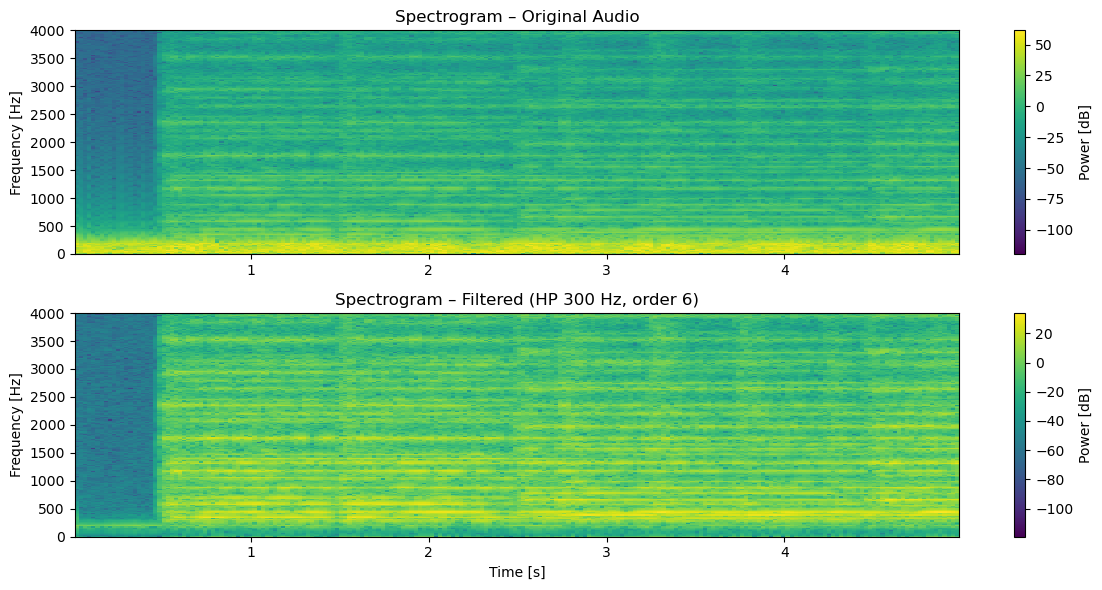

In [59]:
from scipy.signal import spectrogram
import numpy as np
import matplotlib.pyplot as plt

def plot_spec(x, title):
    f, t_spec, Sxx = spectrogram(x, fs, nperseg=2048, noverlap=1024)
    plt.pcolormesh(t_spec, f, 10*np.log10(Sxx + 1e-12), shading="auto")
    plt.ylim(0, 4000)
    plt.ylabel("Frequency [Hz]")
    plt.title(title)
    plt.colorbar(label="Power [dB]")

plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
plot_spec(audio_mono, "Spectrogram – Original Audio")

plt.subplot(2,1,2)
plot_spec(filtered_audio, f"Spectrogram – Filtered (HP {best_cutoff} Hz, order {best_order})")
plt.xlabel("Time [s]")

plt.tight_layout()
plt.show()


## Interpretation of Spectral Results

The Power Spectral Density (PSD) comparison confirms a strong reduction of signal power below the chosen cutoff frequency, spanning several orders of magnitude. Above approximately 300–400 Hz, the PSD retains a similar structure to the original signal, indicating that musical content is largely preserved.

The spectrogram further supports this result. In the original audio, a continuous low-frequency band is visible over the entire duration of the signal, corresponding to the acoustic disturbance. After filtering, this low-frequency band is strongly attenuated, while the time–frequency patterns associated with musical harmonics remain clearly visible.

Together, these analyses demonstrate that the applied filtering effectively reduces the disturbance without eliminating the main musical structure.


In [61]:
from scipy.io import wavfile
import numpy as np

# normalize to prevent clipping
filtered_norm = filtered_audio / np.max(np.abs(filtered_audio))

wavfile.write("mozart_clean_HP300_order6.wav", fs, filtered_norm.astype(np.float32))


## Conclusion

In this project, spectral analysis techniques were applied to an audio time series in order to reduce low-frequency acoustic noise affecting a musical signal.

The FFT and PSD analyses allowed the identification of the frequency range dominated by the disturbance, guiding the design of an appropriate high-pass filter. By selecting a Butterworth high-pass filter with suitable cutoff frequency and order, the low-frequency noise was significantly attenuated while preserving the musical content.

The effectiveness of the procedure was validated through frequency-domain plots, spectrograms, and listening tests. This project highlights the importance of frequency-domain representations in time series analysis and demonstrates how spectral methods can be used to address real-world signal processing problems.
